# BERT裁剪

采用训练数据链接：

https://huggingface.co/datasets/hw2942/financial-news-sentiment

0:Negative, 1:Neutral, 2:Positive

huggingface模型链接：

https://huggingface.co/hw2942/bert-base-chinese-finetuning-financial-news-sentiment-v2

In [1]:
import torch 
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from textpruner import TransformerPruner

# Load model directly
tokenizer = AutoTokenizer.from_pretrained("hw2942/bert-base-chinese-finetuning-financial-news-sentiment-v2")
model = AutoModelForSequenceClassification.from_pretrained("hw2942/bert-base-chinese-finetuning-financial-news-sentiment-v2",output_attentions=True)

# load the dataset 
ds = load_dataset("hw2942/financial-news-sentiment")


d:\Python\lib\site-packages\transformers\modeling_utils.py:460: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location="cpu")
d:\Pytho

In [2]:
n = 1  # 第2层（索引从0开始）
attention_layer = model.bert.encoder.layer[n].attention.self
# 多头中的所有权重会被打包在一起，m 是你感兴趣的头的索引
heads_weight = attention_layer.query.weight  # 例如这里访问 query 的权重
heads_weight

Parameter containing:
tensor([[ 0.0634, -0.0002,  0.0107,  ..., -0.0730, -0.0641,  0.0158],
        [ 0.0112, -0.0260,  0.0082,  ...,  0.0998,  0.0648, -0.0175],
        [ 0.0432,  0.0092,  0.0175,  ...,  0.0038, -0.1050, -0.0408],
        ...,
        [-0.0089, -0.0044,  0.0227,  ...,  0.0486,  0.0171, -0.1026],
        [ 0.0317, -0.0212, -0.0513,  ...,  0.0162,  0.0206,  0.0090],
        [ 0.0252,  0.0828, -0.0401,  ..., -0.0359,  0.0246,  0.0610]],
       requires_grad=True)

In [86]:
# 创建输入数据
input_ids = tokenizer(ds['train'][0]['Title'],return_tensors='pt')  # 示例token ID
outputs = model(**input_ids)

# 获取模型的输出
sequence_output = outputs.logits  # 分类模型的logits输出

# 选择一个标量输出，例如logits的L2范数
loss = torch.norm(sequence_output)

# 反向传播
loss.backward()

# 打印出对head_weight的梯度
print(heads_weight.grad)

tensor([[-2.4871e-04, -4.7463e-04,  4.9912e-04,  ...,  1.0182e-04,
          4.1627e-04,  5.1642e-04],
        [ 1.5761e-04, -6.2480e-04, -3.0400e-04,  ..., -3.0718e-04,
          2.5252e-05, -5.1715e-04],
        [ 4.3950e-04,  3.3384e-05, -5.8299e-04,  ..., -1.7127e-04,
         -4.1708e-04, -1.0099e-03],
        ...,
        [-8.8954e-06, -3.4051e-04, -1.5886e-04,  ..., -2.4521e-04,
          3.6865e-04, -2.5955e-04],
        [ 1.4707e-03, -6.8299e-05, -9.0577e-05,  ..., -5.2714e-04,
          5.9767e-04, -3.3672e-04],
        [-1.4086e-04, -1.1484e-04,  5.5247e-04,  ...,  9.8638e-05,
          5.4058e-04,  6.3561e-04]])


### 需要清除梯度缓存，否则会导致以上代码运行地越多，梯度变得越来越大

In [68]:
model.zero_grad()  # 确保每次反向传播前梯度为零
loss.backward()

# 打印出对head_weight的梯度
print(heads_weight.grad)

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [20]:
# 创建输入数据
input_ids = tokenizer(ds['train'][0]['Title'],return_tensors='pt')  # 示例token ID
outputs = model(**input_ids)

# 获取模型的输出
sequence_output = outputs.logits  # 分类模型的logits输出

# 选择一个标量输出，例如logits的L2范数
loss = torch.norm(sequence_output)

# 反向传播前清除梯度
model.zero_grad()  # 确保每次反向传播前梯度为零

# 保持计算图以便后续可以再次使用
loss.backward(retain_graph=True)

# 打印出对head_weight的梯度
print(heads_weight.grad,heads_weight.grad.size())

tensor([[-2.4871e-04, -4.7463e-04,  4.9912e-04,  ...,  1.0182e-04,
          4.1627e-04,  5.1642e-04],
        [ 1.5761e-04, -6.2480e-04, -3.0400e-04,  ..., -3.0718e-04,
          2.5252e-05, -5.1715e-04],
        [ 4.3950e-04,  3.3384e-05, -5.8299e-04,  ..., -1.7127e-04,
         -4.1708e-04, -1.0099e-03],
        ...,
        [-8.8954e-06, -3.4051e-04, -1.5886e-04,  ..., -2.4521e-04,
          3.6865e-04, -2.5955e-04],
        [ 1.4707e-03, -6.8299e-05, -9.0577e-05,  ..., -5.2714e-04,
          5.9767e-04, -3.3672e-04],
        [-1.4086e-04, -1.1484e-04,  5.5247e-04,  ...,  9.8638e-05,
          5.4058e-04,  6.3561e-04]]) torch.Size([768, 768])


In [21]:
heads_weight.grad[0][100]

tensor(-9.2833e-05)

In [5]:

# 获取 BERT 的配置参数
hidden_size = model.config.hidden_size  # BERT 的隐藏层维度，例如 768
num_attention_heads = model.config.num_attention_heads  # 注意力头的数量，例如 12
head_size = hidden_size // num_attention_heads  # 每个头的维度

# 选择你想要的单个头的索引
head_index = 0  # 选择第一个注意力头（索引从0开始）

# 提取出单个头的 query 权重
# query_weight 的形状为 [hidden_size, hidden_size]，需要切片提取单个头的参数
# 对 query_weight 的第一维度进行切片，获取相应的权重
single_head_weight = heads_weight[:, head_index * head_size:(head_index + 1) * head_size]


In [9]:
single_head_weight.grad

C:\Users\m1830\AppData\Local\Temp\ipykernel_24584\2471559650.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen/core/TensorBody.h:494.)
  single_head_weight.grad


In [80]:
single_head_weight.size()

torch.Size([768, 64])

In [22]:
head_weight.grad.size()

torch.Size([768, 768])

In [32]:
head_mask = torch.tensor(12*[12*[1]])
head_mask[0][0]=0
head_mask

tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [33]:
pruner = TransformerPruner(model)
ffn_mask=torch.tensor([[1]*3072]*12)
pruner.prune(head_mask=head_mask,ffn_mask=ffn_mask,save_model=False)

In [24]:
model.to('cpu')
# 创建输入数据
input_ids = tokenizer(ds['train'][0]['Title'],return_tensors='pt')  # 示例token ID
outputs = model(**input_ids)

# 获取模型的输出
sequence_output = outputs.logits  # 分类模型的logits输出

# 选择一个标量输出，例如logits的L2范数
loss = torch.norm(sequence_output)

# 反向传播前清除梯度
model.zero_grad()  # 确保每次反向传播前梯度为零

# 保持计算图以便后续可以再次使用
loss.backward(retain_graph=True)

# 打印出对head_weight的梯度
print(heads_weight.grad,heads_weight.grad.size())

tensor([[-2.7346e-04, -2.1618e-04,  1.9485e-04,  ...,  2.4316e-05,
          2.4423e-04,  3.5674e-04],
        [ 1.3257e-03, -3.4072e-04, -9.1461e-06,  ..., -3.8282e-04,
         -2.8592e-04, -8.9046e-04],
        [ 1.3701e-03,  1.9329e-04, -3.8640e-04,  ..., -2.7384e-04,
         -5.4856e-04, -1.2977e-03],
        ...,
        [ 3.9116e-04, -1.5989e-04, -2.9226e-04,  ..., -2.4665e-04,
          2.7834e-04, -2.9312e-04],
        [ 1.6195e-03,  1.8898e-04,  8.0555e-06,  ..., -5.2405e-04,
          4.5568e-04, -5.2088e-04],
        [-3.9798e-04, -3.7070e-05,  4.8267e-04,  ...,  6.0957e-05,
          4.6266e-04,  4.2070e-04]]) torch.Size([768, 768])


In [25]:
heads_weight.grad[0][100]

tensor(-7.4403e-05)

In [30]:
n = 0  # 第1层（索引从0开始）
attention_layer = model.bert.encoder.layer[n].attention.self
# 多头中的所有权重会被打包在一起，m 是你感兴趣的头的索引
heads_weight = attention_layer.query.weight  # 例如这里访问 query 的权重
heads_weight

Parameter containing:
tensor([[ 0.1183, -0.0081,  0.0040,  ...,  0.0138,  0.0171, -0.0819],
        [ 0.0080, -0.0235, -0.0055,  ...,  0.0013,  0.0419,  0.0117],
        [ 0.0150,  0.0061,  0.0354,  ...,  0.1125, -0.0318, -0.0137],
        ...,
        [-0.0514,  0.0237,  0.0113,  ...,  0.0543,  0.0055,  0.0721],
        [ 0.0170, -0.0891, -0.0563,  ..., -0.0436,  0.0368, -0.0144],
        [ 0.0128, -0.0325, -0.0010,  ...,  0.0957, -0.0337,  0.0017]],
       requires_grad=True)

In [34]:
model.to('cpu')
# 创建输入数据
input_ids = tokenizer(ds['train'][0]['Title'],return_tensors='pt')  # 示例token ID
outputs = model(**input_ids)

# 获取模型的输出
sequence_output = outputs.logits  # 分类模型的logits输出

# 选择一个标量输出，例如logits的L2范数
loss = torch.norm(sequence_output)

# 反向传播前清除梯度
model.zero_grad()  # 确保每次反向传播前梯度为零

# 保持计算图以便后续可以再次使用
loss.backward(retain_graph=True)

# 打印出对head_weight的梯度
print(heads_weight.grad,heads_weight.grad.size())

tensor([[ 5.7181e-04,  1.6097e-04, -8.2610e-04,  ...,  3.3229e-04,
         -4.7372e-04,  5.0043e-04],
        [-8.2390e-05,  4.5101e-04,  4.1507e-04,  ..., -2.2643e-04,
          2.8777e-04,  4.1227e-05],
        [ 1.9445e-04,  1.0557e-04,  6.6730e-04,  ...,  1.2498e-04,
         -8.1389e-04,  2.1818e-03],
        ...,
        [ 3.0416e-04,  5.4775e-05, -4.6295e-04,  ...,  3.0760e-04,
         -1.2061e-04, -8.1021e-04],
        [ 6.8528e-04,  3.2869e-04, -9.6820e-04,  ...,  1.0962e-03,
         -7.8020e-04, -1.4448e-05],
        [ 9.4563e-05, -8.5372e-04,  6.4145e-04,  ...,  5.2069e-04,
         -6.2215e-05,  9.0355e-04]], device='cuda:0') torch.Size([768, 768])


In [35]:
from textpruner import TransformerPruner

pruner = TransformerPruner(model)

head_mask=torch.tensor(12*[12*[1]])

In [36]:
head_mask[1]=torch.tensor([0]*12)

In [37]:
head_mask

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [38]:
pruner.prune(save_model=False,head_mask=head_mask)

In [39]:
model.to('cpu')
# 创建输入数据
input_ids = tokenizer(ds['train'][0]['Title'],return_tensors='pt')  # 示例token ID
outputs = model(**input_ids)

# 获取模型的输出
sequence_output = outputs.logits  # 分类模型的logits输出

# 选择一个标量输出，例如logits的L2范数
loss = torch.norm(sequence_output)

# 反向传播前清除梯度
model.zero_grad()  # 确保每次反向传播前梯度为零

# 保持计算图以便后续可以再次使用
loss.backward(retain_graph=True)

# 打印出对head_weight的梯度
print(heads_weight.grad,heads_weight.grad.size())

tensor([[ 5.7181e-04,  1.6097e-04, -8.2610e-04,  ...,  3.3229e-04,
         -4.7372e-04,  5.0043e-04],
        [-8.2390e-05,  4.5101e-04,  4.1507e-04,  ..., -2.2643e-04,
          2.8777e-04,  4.1227e-05],
        [ 1.9445e-04,  1.0557e-04,  6.6730e-04,  ...,  1.2498e-04,
         -8.1389e-04,  2.1818e-03],
        ...,
        [ 3.0416e-04,  5.4775e-05, -4.6295e-04,  ...,  3.0760e-04,
         -1.2061e-04, -8.1021e-04],
        [ 6.8528e-04,  3.2869e-04, -9.6820e-04,  ...,  1.0962e-03,
         -7.8020e-04, -1.4448e-05],
        [ 9.4563e-05, -8.5372e-04,  6.4145e-04,  ...,  5.2069e-04,
         -6.2215e-05,  9.0355e-04]], device='cuda:0') torch.Size([768, 768])


# 结论：

在剪过了某些头之后，其他头内部参数的梯度发生变化，所以不能只算一次头的梯度，来得到这个头是否重要。可能需要多次求关于其他的头的偏导才可以。


In [30]:
model(**input_ids).attentions

(tensor([[[[2.2416e-02, 1.3964e-02, 1.0259e-02,  ..., 8.6136e-03,
            4.5173e-03, 7.3297e-01],
           [1.0430e-01, 4.7057e-02, 3.1528e-01,  ..., 2.3341e-04,
            7.2508e-03, 8.3452e-03],
           [3.3869e-02, 4.7658e-01, 8.4863e-03,  ..., 3.8979e-04,
            4.2075e-04, 2.7585e-02],
           ...,
           [2.6577e-02, 1.9967e-03, 1.3971e-03,  ..., 1.9350e-02,
            2.8812e-02, 4.2120e-02],
           [9.3660e-02, 8.7783e-03, 3.4070e-03,  ..., 4.0842e-01,
            3.5635e-02, 2.4212e-01],
           [5.5091e-03, 4.0392e-06, 1.3031e-05,  ..., 2.3731e-06,
            7.7740e-06, 9.9445e-01]],
 
          [[7.0329e-01, 6.5748e-03, 1.4338e-02,  ..., 1.2167e-02,
            1.2683e-02, 1.6100e-02],
           [7.5525e-01, 1.7563e-02, 1.0136e-02,  ..., 9.4450e-03,
            6.5129e-03, 1.6172e-02],
           [6.4728e-01, 2.1073e-02, 1.0803e-01,  ..., 1.3424e-02,
            9.9957e-03, 9.1611e-03],
           ...,
           [1.0018e-01, 6.0616e-02, 2.

In [60]:
input_ids

{'input_ids': tensor([[ 101., 3189., 1039.,  677., 1453., 1112., 4958., 1928., 1928., 2189.,
         1158., 1724.,  702., 3299., 3173.,  856., 5401., 1039.,  120., 3189.,
         1039.,  856.,  855., 4669., 3146.,  102.]]), 'token_type_ids': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]]), 'attention_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1.]])}

In [71]:

# 使得输入可用于梯度计算
input_ids = tokenizer(ds['train'][0]['Title'],return_tensors='pt') 
outputs = model(**input_ids)
attention_outputs = model(**input_ids).attentions  # 提取注意力输出

# 假设我们选取第12层的第1头和第2头
head_1 = attention_outputs[1][0, 0]  # 第2层，第1个注意力头
head_2 = attention_outputs[1][0, 1]  # 第2层，第2个注意力头
head_1.requires_grad_(True)
head_2.requires_grad_(True)
input_ids['input_ids']=input_ids['input_ids'].float()
input_ids['token_type_ids']=input_ids['token_type_ids'].float()
input_ids['attention_mask']=input_ids['attention_mask'].float()
input_ids['input_ids'].requires_grad_(True)
input_ids['token_type_ids'].requires_grad_(True)
input_ids['attention_mask'].requires_grad_(True)
outputs.last_hidden_state.retain_grad()
# 计算第1个头相对于输入的梯度 (一阶导数)
head_1_grad = torch.autograd.grad(head_1.sum(), outputs.last_hidden_state, create_graph=True,allow_unused=True)[0]

# 计算第2个头的混合导数，即对第1个头的梯度再对第2个头进行求导
# 这是混合二阶偏导数
mixed_second_order_derivative = torch.autograd.grad(head_2.sum(), outputs.last_hidden_state, grad_outputs=head_1_grad, create_graph=True,allow_unused=True)[0]

print("混合二阶导数: ", mixed_second_order_derivative)


AttributeError: 'SequenceClassifierOutput' object has no attribute 'last_hidden_state'

求偏导不现实，因为要剪k个头就要求k阶混合偏导，这个144中挑k个的组合数太大，更不用说代码运行时间。

## 现在需要验证一个结论，如果被剪的头被剪后，被剪的头梯度变了，那么再剪别的头时它的梯度就不会再变了

In [40]:
import torch 
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from textpruner import TransformerPruner

# Load model directly
tokenizer = AutoTokenizer.from_pretrained("hw2942/bert-base-chinese-finetuning-financial-news-sentiment-v2")
model = AutoModelForSequenceClassification.from_pretrained("hw2942/bert-base-chinese-finetuning-financial-news-sentiment-v2",output_attentions=True)

# load the dataset 
ds = load_dataset("hw2942/financial-news-sentiment")


In [41]:
n = 1  # 第2层（索引从0开始）
attention_layer = model.bert.encoder.layer[n].attention.self
# 多头中的所有权重会被打包在一起，m 是你感兴趣的头的索引
heads_weight = attention_layer.query.weight  # 例如这里访问 query 的权重
heads_weight

Parameter containing:
tensor([[ 0.0634, -0.0002,  0.0107,  ..., -0.0730, -0.0641,  0.0158],
        [ 0.0112, -0.0260,  0.0082,  ...,  0.0998,  0.0648, -0.0175],
        [ 0.0432,  0.0092,  0.0175,  ...,  0.0038, -0.1050, -0.0408],
        ...,
        [-0.0089, -0.0044,  0.0227,  ...,  0.0486,  0.0171, -0.1026],
        [ 0.0317, -0.0212, -0.0513,  ...,  0.0162,  0.0206,  0.0090],
        [ 0.0252,  0.0828, -0.0401,  ..., -0.0359,  0.0246,  0.0610]],
       requires_grad=True)

In [42]:
model.to('cpu')
# 创建输入数据
input_ids = tokenizer(ds['train'][0]['Title'],return_tensors='pt')  # 示例token ID
outputs = model(**input_ids)

# 获取模型的输出
sequence_output = outputs.logits  # 分类模型的logits输出

# 选择一个标量输出，例如logits的L2范数
loss = torch.norm(sequence_output)

# 反向传播前清除梯度
model.zero_grad()  # 确保每次反向传播前梯度为零

# 保持计算图以便后续可以再次使用
loss.backward(retain_graph=True)

# 打印出对head_weight的梯度
print(heads_weight.grad,heads_weight.grad.size())

tensor([[-2.4871e-04, -4.7463e-04,  4.9912e-04,  ...,  1.0182e-04,
          4.1627e-04,  5.1642e-04],
        [ 1.5761e-04, -6.2480e-04, -3.0400e-04,  ..., -3.0718e-04,
          2.5252e-05, -5.1715e-04],
        [ 4.3950e-04,  3.3384e-05, -5.8299e-04,  ..., -1.7127e-04,
         -4.1708e-04, -1.0099e-03],
        ...,
        [-8.8954e-06, -3.4051e-04, -1.5886e-04,  ..., -2.4521e-04,
          3.6865e-04, -2.5955e-04],
        [ 1.4707e-03, -6.8299e-05, -9.0577e-05,  ..., -5.2714e-04,
          5.9767e-04, -3.3672e-04],
        [-1.4086e-04, -1.1484e-04,  5.5247e-04,  ...,  9.8638e-05,
          5.4058e-04,  6.3561e-04]]) torch.Size([768, 768])


In [46]:
a=heads_weight.grad[1]

In [48]:
n = 3  # 第4层（索引从0开始）
attention_layer = model.bert.encoder.layer[n].attention.self
# 多头中的所有权重会被打包在一起，m 是你感兴趣的头的索引
heads_weight = attention_layer.query.weight  # 例如这里访问 query 的权重
model.to('cpu')
# 创建输入数据
input_ids = tokenizer(ds['train'][0]['Title'],return_tensors='pt')  # 示例token ID
outputs = model(**input_ids)

# 获取模型的输出
sequence_output = outputs.logits  # 分类模型的logits输出

# 选择一个标量输出，例如logits的L2范数
loss = torch.norm(sequence_output)

# 反向传播前清除梯度
model.zero_grad()  # 确保每次反向传播前梯度为零

# 保持计算图以便后续可以再次使用
loss.backward(retain_graph=True)

# 打印出对head_weight的梯度
print(heads_weight.grad,heads_weight.grad.size())

tensor([[-9.3833e-04, -5.8542e-04,  2.3521e-03,  ...,  5.5316e-05,
         -1.2867e-03, -1.0289e-03],
        [ 3.7727e-04,  3.2622e-04, -1.1731e-03,  ...,  1.4615e-04,
          8.9240e-04, -6.0019e-04],
        [ 9.2544e-04,  9.2564e-04, -1.2427e-03,  ..., -2.4506e-04,
         -1.1435e-04,  2.4197e-04],
        ...,
        [ 2.7608e-04,  5.0513e-04,  2.4779e-04,  ...,  8.2564e-05,
         -3.2886e-04, -5.9152e-05],
        [-7.0283e-04, -4.2315e-04, -4.5128e-04,  ...,  8.2481e-05,
          2.4653e-04,  3.4056e-04],
        [ 3.3185e-05, -3.8162e-04, -1.0771e-04,  ..., -1.1146e-04,
          4.0910e-05,  4.1269e-05]]) torch.Size([768, 768])


In [49]:
from textpruner import TransformerPruner

pruner = TransformerPruner(model)

head_mask=torch.tensor(12*[12*[1]])
head_mask[1]=torch.tensor([0]*12)

In [51]:
pruner.prune(save_model=False,head_mask=head_mask)

d:\Python\lib\site-packages\torch\nn\init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [65]:
n = 1  # 第2层（索引从0开始）
attention_layer = model.bert.encoder.layer[n].attention.self
# 多头中的所有权重会被打包在一起，m 是你感兴趣的头的索引
heads_weight = attention_layer.query.weight  # 例如这里访问 query 的权重
model.to('cpu')
# 创建输入数据
input_ids = tokenizer(ds['train'][0]['Title'],return_tensors='pt')  # 示例token ID
outputs = model(**input_ids)

# 获取模型的输出
sequence_output = outputs.logits  # 分类模型的logits输出

# 选择一个标量输出，例如logits的L2范数
loss = torch.norm(sequence_output)

# 反向传播前清除梯度
model.zero_grad()  # 确保每次反向传播前梯度为零

# 保持计算图以便后续可以再次使用
loss.backward(retain_graph=True)

# 打印出对head_weight的梯度
print(heads_weight.grad,heads_weight.grad.size())

tensor([], size=(0, 768)) torch.Size([0, 768])


In [73]:
attention_layer.value.weight.grad.size()[0]


0

In [53]:
n = 3  # 第4层（索引从0开始）
attention_layer = model.bert.encoder.layer[n].attention.self
# 多头中的所有权重会被打包在一起，m 是你感兴趣的头的索引
heads_weight = attention_layer.query.weight  # 例如这里访问 query 的权重
model.to('cpu')
# 创建输入数据
input_ids = tokenizer(ds['train'][0]['Title'],return_tensors='pt')  # 示例token ID
outputs = model(**input_ids)

# 获取模型的输出
sequence_output = outputs.logits  # 分类模型的logits输出

# 选择一个标量输出，例如logits的L2范数
loss = torch.norm(sequence_output)

# 反向传播前清除梯度
model.zero_grad()  # 确保每次反向传播前梯度为零

# 保持计算图以便后续可以再次使用
loss.backward(retain_graph=True)

# 打印出对head_weight的梯度
print(heads_weight.grad,heads_weight.grad.size())

tensor([[-7.9040e-03, -1.1444e-02,  1.1102e-02,  ...,  1.7492e-03,
         -7.2757e-03,  4.0425e-03],
        [-2.1859e-03,  1.3451e-03, -8.8417e-03,  ..., -6.1145e-03,
          7.6276e-03, -8.8556e-03],
        [ 7.9869e-03,  9.9755e-03, -5.9779e-03,  ...,  2.8143e-03,
         -2.1314e-03,  2.3945e-03],
        ...,
        [ 2.5783e-04, -4.8985e-04,  4.0316e-03,  ..., -1.0271e-03,
          1.5244e-03, -2.5975e-03],
        [-5.4784e-03, -3.5003e-05, -5.2764e-03,  ...,  5.6498e-03,
         -4.9502e-03,  2.5676e-04],
        [-7.4197e-04, -1.8828e-03,  1.8733e-03,  ..., -8.3730e-04,
          2.1019e-03, -4.0491e-03]]) torch.Size([768, 768])


## 结论：梯度直接消失没有了，这里需要验证只剪一个头，该层参数的梯度如何

In [74]:
import torch 
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from textpruner import TransformerPruner

# Load model directly
tokenizer = AutoTokenizer.from_pretrained("hw2942/bert-base-chinese-finetuning-financial-news-sentiment-v2")
model = AutoModelForSequenceClassification.from_pretrained("hw2942/bert-base-chinese-finetuning-financial-news-sentiment-v2",output_attentions=True)

# load the dataset 
ds = load_dataset("hw2942/financial-news-sentiment")


d:\Python\lib\site-packages\transformers\modeling_utils.py:460: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location="cpu")
d:\Pytho

In [77]:
n = 1  # 第2层（索引从0开始）
attention_layer = model.bert.encoder.layer[n].attention.self
# 多头中的所有权重会被打包在一起，m 是你感兴趣的头的索引
heads_weight = attention_layer.query.weight  # 例如这里访问 query 的权重
heads_weight

Parameter containing:
tensor([[ 0.0634, -0.0002,  0.0107,  ..., -0.0730, -0.0641,  0.0158],
        [ 0.0112, -0.0260,  0.0082,  ...,  0.0998,  0.0648, -0.0175],
        [ 0.0432,  0.0092,  0.0175,  ...,  0.0038, -0.1050, -0.0408],
        ...,
        [-0.0089, -0.0044,  0.0227,  ...,  0.0486,  0.0171, -0.1026],
        [ 0.0317, -0.0212, -0.0513,  ...,  0.0162,  0.0206,  0.0090],
        [ 0.0252,  0.0828, -0.0401,  ..., -0.0359,  0.0246,  0.0610]],
       device='cuda:0', requires_grad=True)

In [78]:
model.to('cpu')
# 创建输入数据
input_ids = tokenizer(ds['train'][0]['Title'],return_tensors='pt')  # 示例token ID
outputs = model(**input_ids)

# 获取模型的输出
sequence_output = outputs.logits  # 分类模型的logits输出

# 选择一个标量输出，例如logits的L2范数
loss = torch.norm(sequence_output)

# 反向传播前清除梯度
model.zero_grad()  # 确保每次反向传播前梯度为零

# 保持计算图以便后续可以再次使用
loss.backward(retain_graph=True)

# 打印出对head_weight的梯度
print(heads_weight.grad,heads_weight.grad.size())

tensor([[-2.4871e-04, -4.7463e-04,  4.9912e-04,  ...,  1.0182e-04,
          4.1627e-04,  5.1642e-04],
        [ 1.5761e-04, -6.2480e-04, -3.0400e-04,  ..., -3.0718e-04,
          2.5252e-05, -5.1715e-04],
        [ 4.3950e-04,  3.3384e-05, -5.8299e-04,  ..., -1.7127e-04,
         -4.1708e-04, -1.0099e-03],
        ...,
        [-8.8954e-06, -3.4051e-04, -1.5886e-04,  ..., -2.4521e-04,
          3.6865e-04, -2.5955e-04],
        [ 1.4707e-03, -6.8299e-05, -9.0577e-05,  ..., -5.2714e-04,
          5.9767e-04, -3.3672e-04],
        [-1.4086e-04, -1.1484e-04,  5.5247e-04,  ...,  9.8638e-05,
          5.4058e-04,  6.3561e-04]]) torch.Size([768, 768])


In [75]:
from textpruner import TransformerPruner

pruner = TransformerPruner(model)

head_mask=torch.tensor(12*[12*[1]])
head_mask[1][0]=0

In [76]:
head_mask

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [79]:
pruner.prune(save_model=False,head_mask=head_mask)

In [80]:
model.to('cpu')
# 创建输入数据
input_ids = tokenizer(ds['train'][0]['Title'],return_tensors='pt')  # 示例token ID
outputs = model(**input_ids)

# 获取模型的输出
sequence_output = outputs.logits  # 分类模型的logits输出

# 选择一个标量输出，例如logits的L2范数
loss = torch.norm(sequence_output)

# 反向传播前清除梯度
model.zero_grad()  # 确保每次反向传播前梯度为零

# 保持计算图以便后续可以再次使用
loss.backward(retain_graph=True)

# 打印出对head_weight的梯度
print(heads_weight.grad,heads_weight.grad.size())

tensor([[-2.4871e-04, -4.7463e-04,  4.9912e-04,  ...,  1.0182e-04,
          4.1627e-04,  5.1642e-04],
        [ 1.5761e-04, -6.2480e-04, -3.0400e-04,  ..., -3.0718e-04,
          2.5252e-05, -5.1715e-04],
        [ 4.3950e-04,  3.3384e-05, -5.8299e-04,  ..., -1.7127e-04,
         -4.1708e-04, -1.0099e-03],
        ...,
        [-8.8954e-06, -3.4051e-04, -1.5886e-04,  ..., -2.4521e-04,
          3.6865e-04, -2.5955e-04],
        [ 1.4707e-03, -6.8299e-05, -9.0577e-05,  ..., -5.2714e-04,
          5.9767e-04, -3.3672e-04],
        [-1.4086e-04, -1.1484e-04,  5.5247e-04,  ...,  9.8638e-05,
          5.4058e-04,  6.3561e-04]]) torch.Size([768, 768])


In [83]:
attention_layer.query.weight.shape

torch.Size([704, 768])

验证 $$\frac{\frac{\partial F}{\partial K_j}}{\frac{\partial u_{ij}}{\partial K_j}} = \frac{\frac{\partial F}{\partial Q_i}}{\frac{\partial u_{ij}}{\partial Q_i}}=\frac{\partial F}{\partial u_{ij}}$$


In [5]:
n = 1  # 第2层（索引从0开始）
attention_layer = model.bert.encoder.layer[n].attention.self
# 多头中的所有权重会被打包在一起，m 是你感兴趣的头的索引
heads_weight_Q_2thlayer = attention_layer.query.weight  # 例如这里访问 query 的权重
heads_weight_Q_2thlayer.size()

torch.Size([768, 768])

In [6]:
heads_weight_K_2thlayer = attention_layer.key.weight  # 例如这里访问 query 的权重
heads_weight_K_2thlayer.size()

torch.Size([768, 768])

In [28]:
model.to('cpu')
# 创建输入数据
input_ids = tokenizer(ds['train'][0]['Title'],return_tensors='pt')  # 示例token ID
outputs = model(**input_ids)

# 获取模型的输出
sequence_output = outputs.logits  # 分类模型的logits输出

# 选择一个标量输出，例如logits的L2范数
loss = torch.norm(sequence_output)

# 反向传播前清除梯度
model.zero_grad()  # 确保每次反向传播前梯度为零

# 保持计算图以便后续可以再次使用
loss.backward(retain_graph=True)

In [29]:
heads_weight_Q_2thlayer.grad,heads_weight_K_2thlayer.grad

(tensor([[-2.4871e-04, -4.7463e-04,  4.9912e-04,  ...,  1.0182e-04,
           4.1627e-04,  5.1642e-04],
         [ 1.5761e-04, -6.2480e-04, -3.0400e-04,  ..., -3.0718e-04,
           2.5252e-05, -5.1715e-04],
         [ 4.3950e-04,  3.3384e-05, -5.8299e-04,  ..., -1.7127e-04,
          -4.1708e-04, -1.0099e-03],
         ...,
         [-8.8954e-06, -3.4051e-04, -1.5886e-04,  ..., -2.4521e-04,
           3.6865e-04, -2.5955e-04],
         [ 1.4707e-03, -6.8299e-05, -9.0577e-05,  ..., -5.2714e-04,
           5.9767e-04, -3.3672e-04],
         [-1.4086e-04, -1.1484e-04,  5.5247e-04,  ...,  9.8638e-05,
           5.4058e-04,  6.3561e-04]]),
 tensor([[-1.4614e-03,  6.4599e-04,  1.0378e-03,  ...,  1.6211e-04,
           1.5565e-04,  1.2345e-04],
         [-4.6430e-04,  4.0170e-04,  3.7591e-04,  ..., -1.3523e-05,
           3.1846e-04,  5.1352e-05],
         [ 1.4723e-03,  5.6938e-04, -5.6556e-04,  ..., -3.3249e-05,
          -5.4656e-04, -1.8784e-04],
         ...,
         [ 6.2536e-04, -6

In [30]:
heads_weight_Q_2thlayer_grad=heads_weight_Q_2thlayer.grad
heads_weight_K_2thlayer_grad=heads_weight_K_2thlayer.grad

In [31]:
heads_weight_Q_2thlayer_grad=heads_weight_Q_2thlayer_grad.view(12,64,768)
heads_weight_K_2thlayer_grad=heads_weight_K_2thlayer_grad.view(12,64,768)
heads_weight_Q_2thlayer_grad.size(),heads_weight_K_2thlayer_grad.size()

(torch.Size([12, 64, 768]), torch.Size([12, 64, 768]))

In [32]:
Q1thhead2thlayer_grad = heads_weight_Q_2thlayer_grad[0].T
K1thhead2thlayer_grad = heads_weight_K_2thlayer_grad[0].T

In [33]:
heads_weight_Q_2thlayer_weight = heads_weight_Q_2thlayer.view(12,64,768)
heads_weight_K_2thlayer_weight = heads_weight_K_2thlayer.view(12,64,768)
Q1thhead2thlayer_weight = heads_weight_Q_2thlayer_weight[0].T
K1thhead2thlayer_weight = heads_weight_K_2thlayer_weight[0].T

In [44]:
a=sum(K1thhead2thlayer_grad[0]*Q1thhead2thlayer_weight[0])/sum(Q1thhead2thlayer_weight[0]**2)
b=sum(Q1thhead2thlayer_grad[0]*K1thhead2thlayer_weight[0])/sum(K1thhead2thlayer_weight[0]**2)

In [45]:
a

tensor(0.0009, grad_fn=<DivBackward0>)

In [46]:
b

tensor(-0.0033, grad_fn=<DivBackward0>)

In [47]:
sum((Q1thhead2thlayer_grad[0]+K1thhead2thlayer_grad[0])*(K1thhead2thlayer_weight[0]+Q1thhead2thlayer_weight[0]))/sum((K1thhead2thlayer_weight[0]+Q1thhead2thlayer_weight[0])**2)

tensor(-0.0025, grad_fn=<DivBackward0>)

# 梯度修剪前后比较

In [ ]:
import torch 
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from textpruner import TransformerPruner

# Load model directly
tokenizer = AutoTokenizer.from_pretrained("hw2942/bert-base-chinese-finetuning-financial-news-sentiment-v2")
model = AutoModelForSequenceClassification.from_pretrained("hw2942/bert-base-chinese-finetuning-financial-news-sentiment-v2",output_attentions=True)

# load the dataset 
ds = load_dataset("hw2942/financial-news-sentiment")


In [42]:
n = 1  # 第2层（索引从0开始）
attention_layer = model.bert.encoder.layer[n].attention.self
# 多头中的所有权重会被打包在一起，m 是你感兴趣的头的索引
heads_weight_Q_2thlayer = attention_layer.query.weight  # 例如这里访问 query 的权重
heads_weight_Q_2thlayer.size()

torch.Size([768, 768])

In [43]:
model.to('cpu')
# 创建输入数据
input_ids = tokenizer(ds['train'][0]['Title'],return_tensors='pt')  # 示例token ID
outputs = model(**input_ids)

# 获取模型的输出
sequence_output = outputs.logits  # 分类模型的logits输出

# 选择一个标量输出，例如logits的L2范数
loss = torch.norm(sequence_output)

# 反向传播前清除梯度
model.zero_grad()  # 确保每次反向传播前梯度为零

# 保持计算图以便后续可以再次使用
loss.backward(retain_graph=True)

<Axes: >

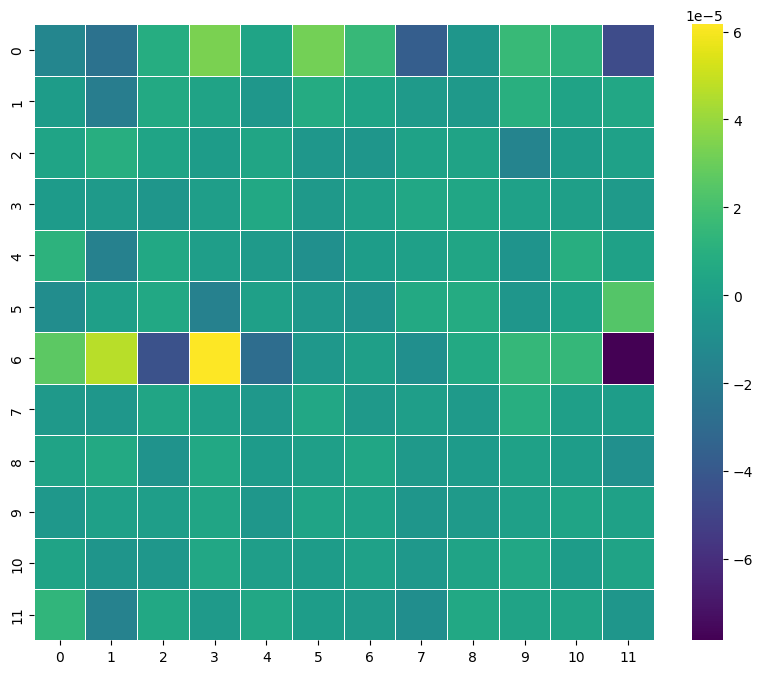

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

grad = heads_weight_Q_2thlayer.grad

downsampled_data = torch.nn.functional.avg_pool2d(grad.unsqueeze(0).unsqueeze(0), kernel_size=64).squeeze(0).squeeze(0)

# 将下采样后的张量转换为 NumPy 数组
data = downsampled_data.detach().numpy()

# 使用 Seaborn 的 heatmap 函数来绘制下采样后的热图
plt.figure(figsize=(10, 8))
sns.heatmap(data, annot=False, fmt=".2f", cmap='viridis', linewidths=0.5)


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

-->

tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [26]:
from textpruner import TransformerPruner

pruner = TransformerPruner(model)

head_mask=torch.tensor(12*[12*[1]])
head_mask[0][0]=torch.tensor(0)

In [27]:
head_mask

tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [28]:
pruner.prune(head_mask=head_mask, save_model=False)

In [29]:
model.to('cpu')
# 创建输入数据
input_ids = tokenizer(ds['train'][0]['Title'],return_tensors='pt')  # 示例token ID
outputs = model(**input_ids)

# 获取模型的输出
sequence_output = outputs.logits  # 分类模型的logits输出

# 选择一个标量输出，例如logits的L2范数
loss = torch.norm(sequence_output)

# 反向传播前清除梯度
model.zero_grad()  # 确保每次反向传播前梯度为零

# 保持计算图以便后续可以再次使用
loss.backward(retain_graph=True)

<Axes: >

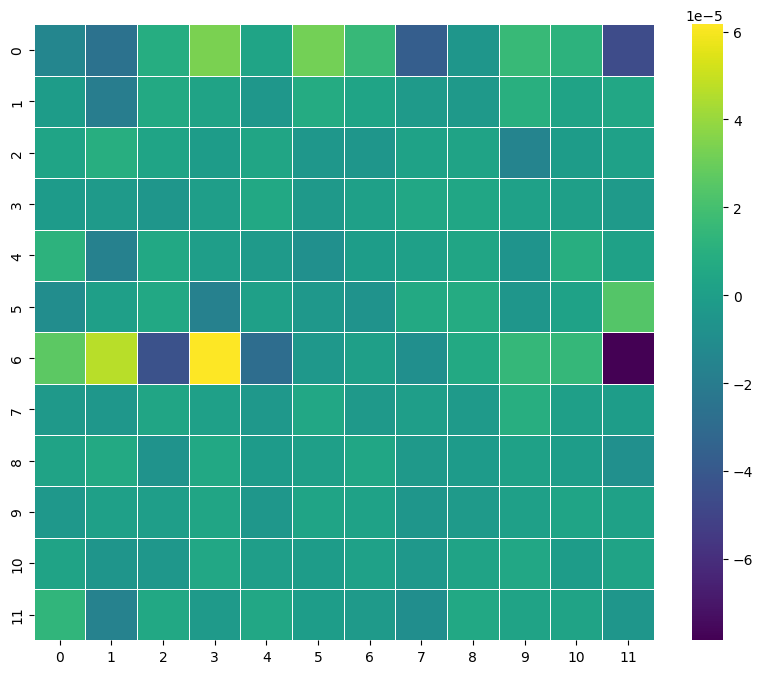

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pruned_grad = heads_weight_Q_2thlayer.grad

pruned_downsampled_data = torch.nn.functional.avg_pool2d(grad.unsqueeze(0).unsqueeze(0), kernel_size=64).squeeze(0).squeeze(0)

# 将下采样后的张量转换为 NumPy 数组
data = downsampled_data.detach().numpy()

# 使用 Seaborn 的 heatmap 函数来绘制下采样后的热图
plt.figure(figsize=(10, 8))
sns.heatmap(data, annot=False, fmt=".2f", cmap='viridis', linewidths=0.5)


<Axes: >

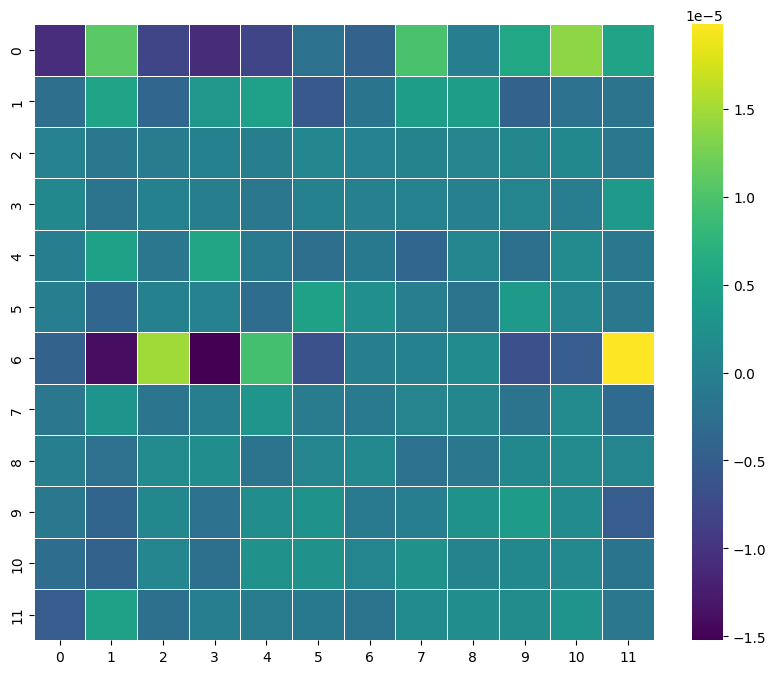

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pruned_grad = heads_weight_Q_2thlayer.grad

__data = torch.nn.functional.avg_pool2d(((pruned_grad-grad)).unsqueeze(0).unsqueeze(0), kernel_size=64).squeeze(0).squeeze(0)

# 将下采样后的张量转换为 NumPy 数组
data = __data.detach().numpy()

# 使用 Seaborn 的 heatmap 函数来绘制下采样后的热图
plt.figure(figsize=(10, 8))
sns.heatmap(data, annot=False, fmt=".2f", cmap='viridis', linewidths=0.5)


In [38]:
import torch 
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from textpruner import TransformerPruner

# Load model directly
tokenizer = AutoTokenizer.from_pretrained("hw2942/bert-base-chinese-finetuning-financial-news-sentiment-v2")
model = AutoModelForSequenceClassification.from_pretrained("hw2942/bert-base-chinese-finetuning-financial-news-sentiment-v2",output_attentions=True)

# load the dataset 
ds = load_dataset("hw2942/financial-news-sentiment")


d:\Python\lib\site-packages\transformers\modeling_utils.py:460: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location="cpu")
d:\Pytho

In [ ]:
from textpruner import TransformerPruner

pruner = TransformerPruner(model)

head_mask=torch.tensor(12*[12*[1]])
head_mask[1][1]=torch.tensor(0)
head_mask

In [ ]:
pruner.prune(head_mask=head_mask, save_model=False)

In [52]:
n = 1  # 第2层（索引从0开始）
attention_layer = model.bert.encoder.layer[n].attention.self
# 多头中的所有权重会被打包在一起，m 是你感兴趣的头的索引
heads_weight_Q_2thlayer = attention_layer.query.weight  # 例如这里访问 query 的权重
heads_weight_Q_2thlayer.size()

torch.Size([704, 768])

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

-->

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [62]:
model.to('cpu')
# 创建输入数据
input_ids = tokenizer(ds['train'][0]['Title'],return_tensors='pt')  # 示例token ID
outputs = model(**input_ids)

# 获取模型的输出
sequence_output = outputs.logits  # 分类模型的logits输出

# 选择一个标量输出，例如logits的L2范数
loss = torch.norm(sequence_output)

# 反向传播前清除梯度
model.zero_grad()  # 确保每次反向传播前梯度为零

# 保持计算图以便后续可以再次使用
loss.backward(retain_graph=True)

In [63]:
pruned_grad = heads_weight_Q_2thlayer.grad

In [64]:
pruned_grad.size()

torch.Size([704, 768])

In [55]:
def expand_weights_to_768x768(tensor, pruned_heads):
    # 初始化列表，存储拼接的张量
    tensors_to_concat = []
    start = 0
    # 按照 pruned_heads 进行插入
    for head_idx, keep in enumerate(pruned_heads):
        if keep == 1:
            # 如果该头保留，保留原来的 64x768
            tensors_to_concat.append(tensor[start:start+64, :])
            start += 64  # 每次移动 64 行
        else:
            # 如果该头被剪掉，插入 64x768 的零矩阵
            tensors_to_concat.append(torch.zeros(64, tensor.size(1)).to(tensor.device)) 
    # 将所有部分拼接起来，得到最终的 768x768 张量
    expanded_tensor = torch.cat(tensors_to_concat, dim=0)
    return expanded_tensor

In [65]:
expanded=expand_weights_to_768x768(pruned_grad, [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],)

In [66]:
expanded

tensor([[-3.0895e-04, -4.4732e-04,  5.0412e-04,  ...,  9.6234e-05,
          3.9502e-04,  5.4519e-04],
        [ 4.7686e-04, -5.1584e-04, -2.2737e-04,  ..., -3.6277e-04,
         -4.3752e-06, -5.6137e-04],
        [ 8.2640e-04,  2.4393e-04, -6.6715e-04,  ..., -2.8535e-04,
         -4.9796e-04, -1.1981e-03],
        ...,
        [ 3.2160e-05, -3.5559e-04, -2.3101e-04,  ..., -2.9017e-04,
          4.1452e-04, -2.5832e-04],
        [ 1.4643e-03, -7.0267e-05, -1.3691e-04,  ..., -5.6653e-04,
          6.4252e-04, -4.0457e-04],
        [-1.2116e-04, -5.0179e-06,  5.6153e-04,  ...,  1.4062e-04,
          4.3794e-04,  5.9372e-04]])

In [78]:
pruned_downsampled_data==0

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True],
        [False, False, False, False, False, False, False, False, False, False,
         False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False],
        [False, False, False, False, False, False, False, False, False, F

<Axes: >

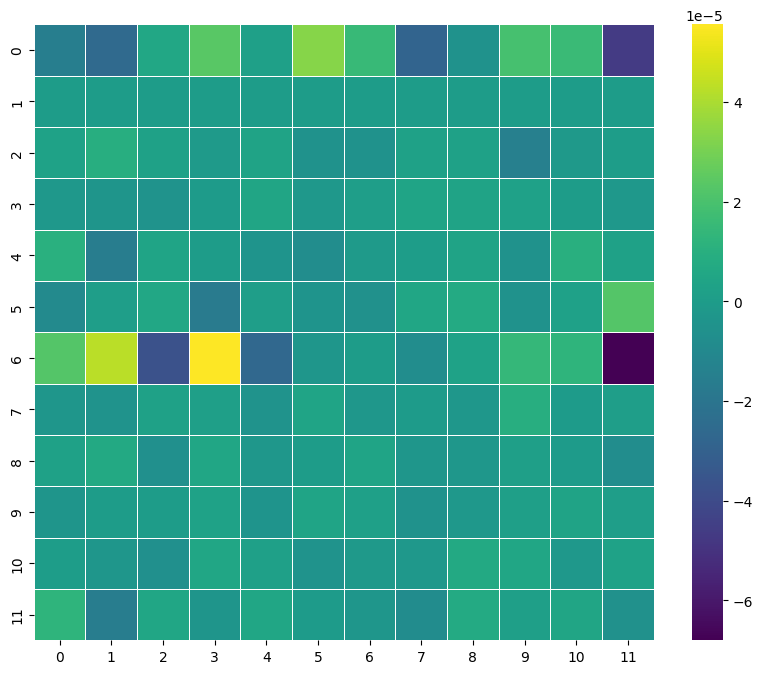

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pruned_downsampled_data = torch.nn.functional.avg_pool2d(expanded.unsqueeze(0).unsqueeze(0), kernel_size=64).squeeze(0).squeeze(0)

# 将下采样后的张量转换为 NumPy 数组
data = pruned_downsampled_data.detach().numpy()

# 使用 Seaborn 的 heatmap 函数来绘制下采样后的热图
plt.figure(figsize=(10, 8))
sns.heatmap(data, annot=False, fmt=".2f", cmap='viridis', linewidths=0.5)


In [90]:
expanded.to('cpu')-grad.to('cpu')

tensor([[-6.0234e-05,  2.7303e-05,  5.0017e-06,  ..., -5.5830e-06,
         -2.1251e-05,  2.8767e-05],
        [ 3.1925e-04,  1.0895e-04,  7.6633e-05,  ..., -5.5594e-05,
         -2.9627e-05, -4.4221e-05],
        [ 3.8690e-04,  2.1055e-04, -8.4163e-05,  ..., -1.1408e-04,
         -8.0883e-05, -1.8829e-04],
        ...,
        [ 4.1055e-05, -1.5080e-05, -7.2158e-05,  ..., -4.4961e-05,
          4.5867e-05,  1.2338e-06],
        [-6.4055e-06, -1.9678e-06, -4.6333e-05,  ..., -3.9385e-05,
          4.4856e-05, -6.7847e-05],
        [ 1.9701e-05,  1.0982e-04,  9.0587e-06,  ...,  4.1983e-05,
         -1.0264e-04, -4.1888e-05]])

In [93]:
torch.nn.functional.avg_pool2d(grad.unsqueeze(0).unsqueeze(0), kernel_size=64).squeeze(0).squeeze(0)


tensor([[-1.4219e-05, -2.5768e-05,  8.2757e-06,  3.3295e-05,  3.2264e-06,
          3.1769e-05,  1.5409e-05, -3.7171e-05, -4.8013e-06,  1.5994e-05,
          1.1378e-05, -4.6372e-05],
        [-1.7727e-06, -1.9918e-05,  6.2925e-06,  2.6289e-06, -4.4849e-06,
          7.0756e-06,  3.1787e-06, -2.4790e-06, -3.2432e-06,  1.0016e-05,
          2.9412e-06,  5.0679e-06],
        [ 3.3330e-06,  9.1206e-06,  3.3667e-06, -1.8496e-06,  4.0062e-06,
         -4.5837e-06, -5.0212e-06,  2.5179e-06,  2.9977e-06, -1.5282e-05,
         -1.6864e-06,  1.0525e-06],
        [-1.9569e-06, -2.7728e-06, -4.9660e-06, -6.3421e-07,  5.3859e-06,
         -3.2925e-06,  4.3605e-07,  5.1308e-06,  4.5271e-06,  1.2605e-06,
          2.0085e-08, -2.6638e-06],
        [ 1.1733e-05, -1.7280e-05,  5.6780e-06, -5.5208e-07, -2.6383e-06,
         -8.4926e-06, -1.1593e-06,  7.9904e-07,  4.0593e-06, -5.8550e-06,
          9.4146e-06,  1.6090e-06],
        [-1.0435e-05,  7.5152e-08,  5.6060e-06, -1.7710e-05,  3.8629e-07,
      

<Axes: >

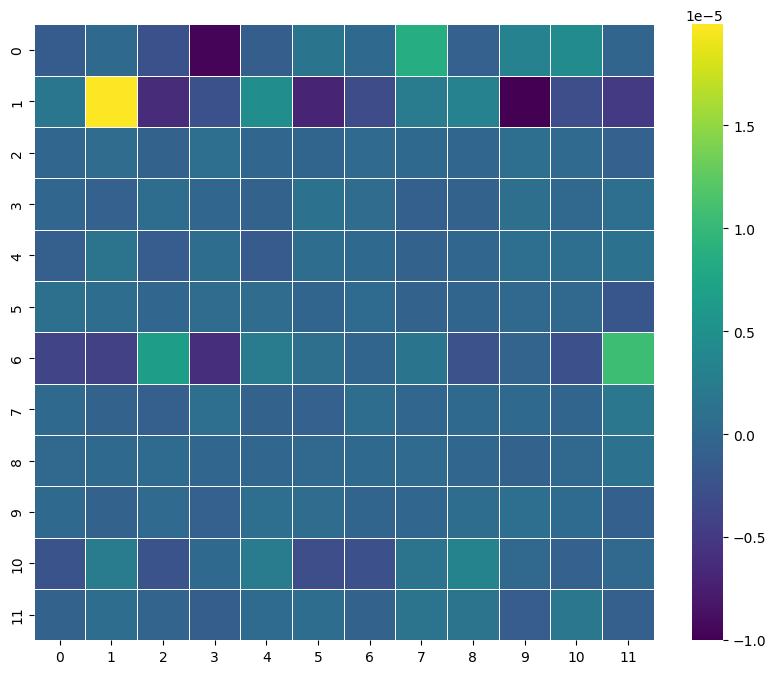

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

__data = torch.nn.functional.avg_pool2d((expanded.to('cpu')-grad.to('cpu')).unsqueeze(0).unsqueeze(0), kernel_size=64).squeeze(0).squeeze(0)

# 将下采样后的张量转换为 NumPy 数组
data = __data.detach().numpy()

# 使用 Seaborn 的 heatmap 函数来绘制下采样后的热图
plt.figure(figsize=(10, 8))
sns.heatmap(data, annot=False, fmt=".2f", cmap='viridis', linewidths=0.5)


测试梯度矩阵形状变化

In [1]:
import torch 
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from textpruner import TransformerPruner
# Load model directly
tokenizer = AutoTokenizer.from_pretrained("hw2942/bert-base-chinese-finetuning-financial-news-sentiment-v2")
model = AutoModelForSequenceClassification.from_pretrained("hw2942/bert-base-chinese-finetuning-financial-news-sentiment-v2",output_attentions=True)
# load the dataset 
ds = load_dataset("hw2942/financial-news-sentiment")

d:\Python\lib\site-packages\transformers\modeling_utils.py:460: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location="cpu")
d:\Pytho

In [2]:
n = 1  # 第2层（索引从0开始）
attention_layer = model.bert.encoder.layer[n].attention.self
# 多头中的所有权重会被打包在一起，m 是你感兴趣的头的索引
heads_weight_Q_2thlayer = attention_layer.query.weight  # 例如这里访问 query 的权重
heads_weight_Q_2thlayer.size()

torch.Size([768, 768])

In [4]:
pruner=TransformerPruner(model)
head_mask=torch.tensor(12*[[1]*12])
head_mask[1][0]=0

In [5]:
head_mask

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [6]:
pruner.prune(save_model=False,head_mask=head_mask)


In [8]:
n = 1  # 第2层（索引从0开始）
attention_layer = model.bert.encoder.layer[n].attention.self
# 多头中的所有权重会被打包在一起，m 是你感兴趣的头的索引
heads_weight_Q_2thlayer = attention_layer.query.weight  # 例如这里访问 query 的权重
heads_weight_Q_2thlayer.size()

torch.Size([704, 768])

In [9]:
n = 1  # 第2层（索引从0开始）
attention_layer = model.bert.encoder.layer[n].attention.self
# 多头中的所有权重会被打包在一起，m 是你感兴趣的头的索引
heads_weight_K_2thlayer = attention_layer.key.weight  # 例如这里访问 query 的权重
heads_weight_K_2thlayer.size()

torch.Size([704, 768])

In [10]:
n = 1  # 第2层（索引从0开始）
attention_layer = model.bert.encoder.layer[n].attention.self
# 多头中的所有权重会被打包在一起，m 是你感兴趣的头的索引
heads_weight_V_2thlayer = attention_layer.value.weight  # 例如这里访问 query 的权重
heads_weight_V_2thlayer.size()

torch.Size([704, 768])

以后没准可以用这个试试可不可以剪，至少可以用它内置的方法得到头部掩码

In [12]:
model.get_head_mask(head_mask,num_hidden_layers=12)

tensor([[[[[1.]],

          [[1.]],

          [[1.]],

          [[1.]],

          [[1.]],

          [[1.]],

          [[1.]],

          [[1.]],

          [[1.]],

          [[1.]],

          [[1.]],

          [[1.]]]],



        [[[[0.]],

          [[1.]],

          [[1.]],

          [[1.]],

          [[1.]],

          [[1.]],

          [[1.]],

          [[1.]],

          [[1.]],

          [[1.]],

          [[1.]],

          [[1.]]]],



        [[[[1.]],

          [[1.]],

          [[1.]],

          [[1.]],

          [[1.]],

          [[1.]],

          [[1.]],

          [[1.]],

          [[1.]],

          [[1.]],

          [[1.]],

          [[1.]]]],



        [[[[1.]],

          [[1.]],

          [[1.]],

          [[1.]],

          [[1.]],

          [[1.]],

          [[1.]],

          [[1.]],

          [[1.]],

          [[1.]],

          [[1.]],

          [[1.]]]],



        [[[[1.]],

          [[1.]],

          [[1.]],

          [[1.]